In [1]:
# =============
# CARGA DE LIBRERIAS

from astropy.io import fits
import gc
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import pickle
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# =============
# CARGA DE DATASETS

# Definir la clase Dataset
class SpectraDataset(Dataset):
    def __init__(self, dataset_path):
        # Cargamos el diccionario previamente guardado (.pt)
        data = torch.load(dataset_path)
        self.flux = data["flux"]              # Tensor con forma [N, num_points]
        self.wavelength = data["wavelength"]  # Tensor con forma [N, num_points]
        self.redshift = data["redshift"]      # Tensor con forma [N]
    
    def __len__(self):
        return self.flux.shape[0]
    
    def __getitem__(self, idx):
        input_sample = torch.stack([self.flux[idx], self.wavelength[idx]], dim=0)  # [2, num_points]
        target = self.redshift[idx]
        return input_sample, target

# Rutas a los archivos preprocesados
data_dir = "data"
train_dataset_path = os.path.join(data_dir, "train_dataset_600k.pt")
test_dataset_path  = os.path.join(data_dir, "test_dataset_600k.pt")

# Crear los datasets
train_dataset = SpectraDataset(train_dataset_path)
test_dataset  = SpectraDataset(test_dataset_path)

# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [2]:
# =============
# DEFINICION Y CONFIGURACION DEL MODELO

class CNN(nn.Module):
    def __init__(self, num_points):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        conv_output_size = num_points // 32
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * conv_output_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instanciar el modelo y moverlo a GPU si está disponible
num_points = 5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelCNN = CNN(num_points).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print("Modelo configurado correctamente.")

Modelo configurado correctamente.


In [ ]:
# =============
# INICIALIZACION DEL MODELO

# Cargar checkpoint y estados del modelo, optimizador y scheduler
model_path = 'storage/modelCNN_600k_0.pth'
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    modelCNN.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
    best_val_loss = float('inf')
    print("No hay checkpoint previo. Entrenamiento desde cero.")
    
# Definir el numero total de epochs que deseas entrenar
num_epochs = 30
best_val_loss = float('inf')  # Para guardar el checkpoint en caso de mejora

# Continuar el entrenamiento desde el epoch donde se quedo
for epoch in range(start_epoch, num_epochs):
    modelCNN.train()
    running_loss = 0.0
    
    # Bucle de entrenamiento con barra de progreso
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Entrenamiento"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = modelCNN(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    
    # Evaluacion en el conjunto de validacion
    modelCNN.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validación"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = modelCNN(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(test_dataset)
    
    # Actualizar la tasa de aprendizaje segun la perdida de validacion
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.10f}", flush=True)
    
    # Guardar el checkpoint si hay mejora en la perdida de validacion
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': modelCNN.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }
        torch.save(checkpoint, 'storage/modelCNN_600k_0.pth')
        print("Checkpoint guardado con éxito.")

# Evaluacion final en el conjunto de prueba utilizando L1
modelCNN.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = modelCNN(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_X.size(0)
test_loss /= len(test_dataset)
print(f"Error absoluto medio en el conjunto de prueba: {test_loss:.4f}")

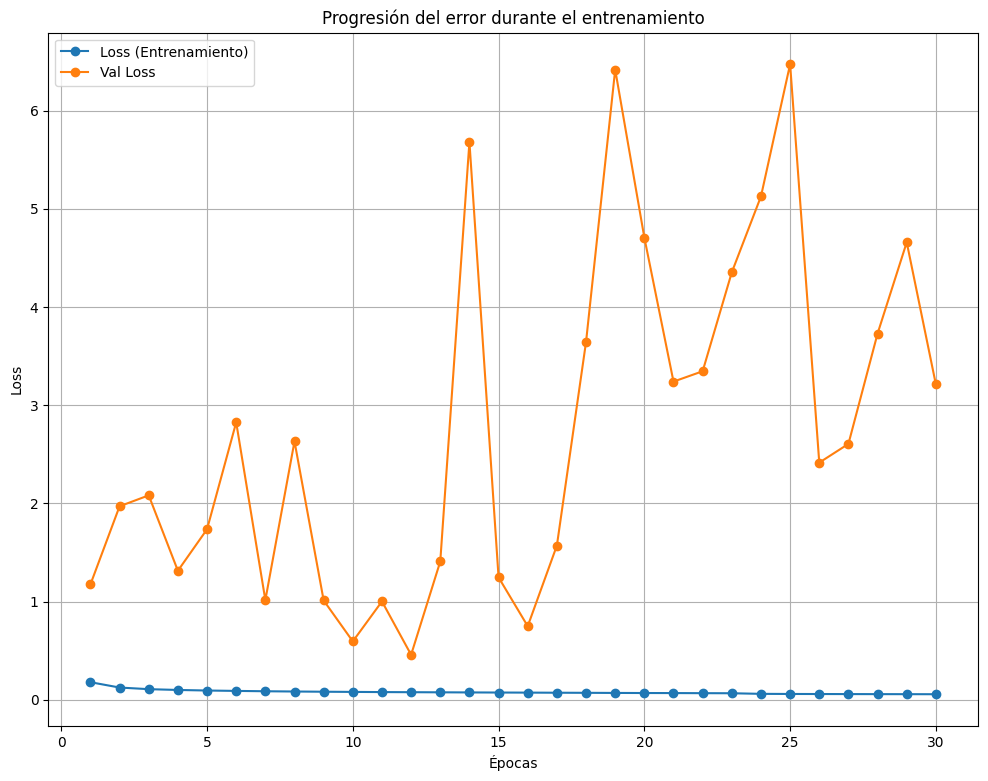

In [4]:
import matplotlib.pyplot as plt

# Datos extraidos de los logs
epochs = list(range(1, 31))
loss = [0.1789, 0.1246, 0.1080, 0.0999, 0.0942, 0.0902, 0.0867, 0.0841, 0.0819, 0.0800,
        0.0783, 0.0771, 0.0759, 0.0748, 0.0737, 0.0729, 0.0717, 0.0708, 0.0696, 0.0687,
        0.0682, 0.0672, 0.0664, 0.0603, 0.0591, 0.0585, 0.0579, 0.0574, 0.0570, 0.0565]
val_loss = [1.1743, 1.9705, 2.0817, 1.3139, 1.7364, 2.8252, 1.0151, 2.6315, 1.0116, 0.5944,
            1.0017, 0.4581, 1.4082, 5.6811, 1.2463, 0.7493, 1.5705, 3.6436, 6.4175, 4.7067,
            3.2400, 3.3455, 4.3530, 5.1257, 6.4721, 2.4149, 2.6056, 3.7291, 4.6586, 3.2114]

# Crear la grafica
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, marker='o', label='Loss (Entrenamiento)')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Progresión del error durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# =============
# EVALUACION Y REPRESENTACION EN BASE A LOS DATASETS USADOS HASTA AHORA

# Cargar checkpoint y estados del modelo, optimizador y scheduler
checkpoint = torch.load('storage/modelCNN_600k_0.pth', map_location=device)
modelCNN.load_state_dict(checkpoint['model_state_dict'])

all_preds = []
all_y = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        preds = modelCNN(inputs).cpu().numpy()  # forma: (batch_size, 1)
        all_preds.append(preds)
        all_y.append(targets.numpy())
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        preds = modelCNN(inputs).cpu().numpy()  # forma: (batch_size, 1)
        all_preds.append(preds)
        all_y.append(targets.numpy())

# Concatenar y convertir a vectores 1D
preds_all = np.concatenate(all_preds, axis=0).squeeze()
y_all = np.concatenate(all_y, axis=0).squeeze()

# Calcular la correlación lineal
corr = np.corrcoef(y_all, preds_all)[0, 1]
print(f"Correlación lineal: {corr:.4f}")

# Ajuste lineal: calcular pendiente e interseccion
slope, intercept = np.polyfit(y_all, preds_all, 1)
print("Slope:", slope)
print("Intercept:", intercept)

Correlación lineal: 0.0010
Slope: 0.4688130748186488
Intercept: 0.8476348656074097


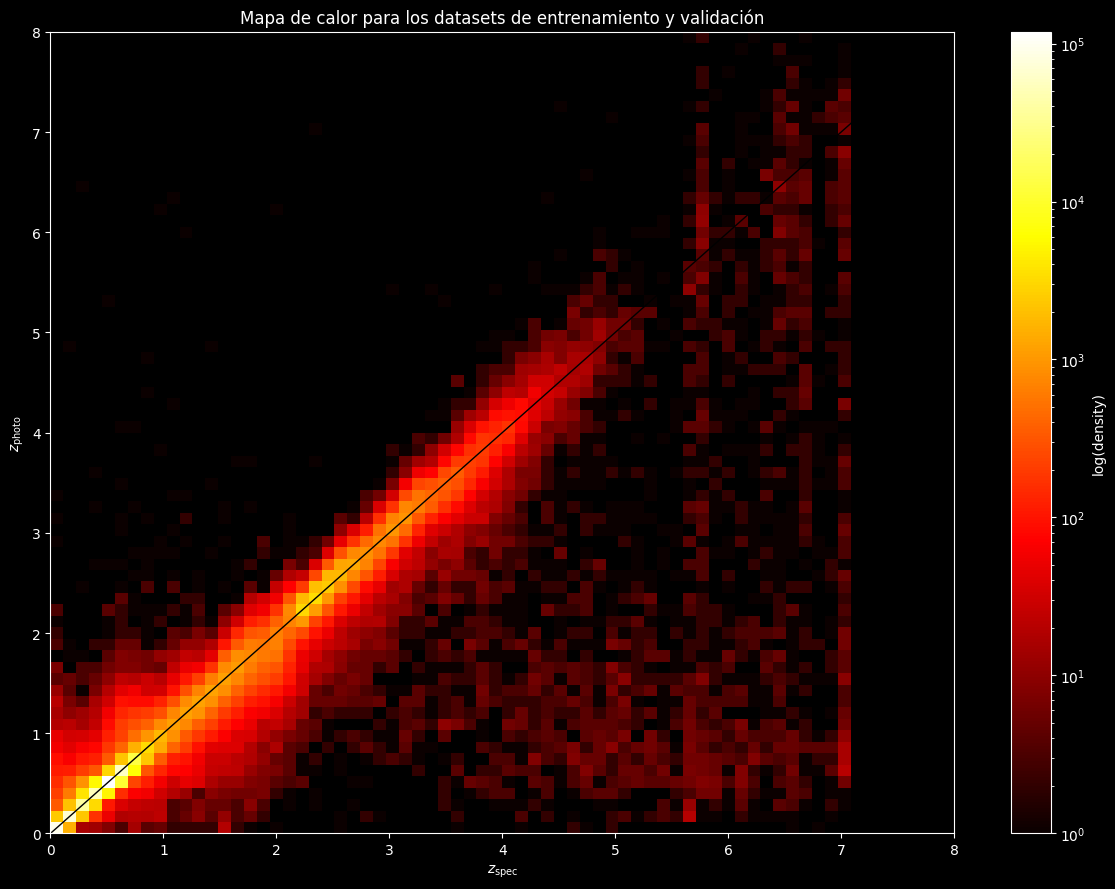

In [6]:
# Mapa de calor de z_real frente a z_predicho
plt.style.use('dark_background')
x_min, x_max = 0, 8
y_min, y_max = 0, 8
plt.figure(figsize=(12, 9))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    y_all,                 # z_spec (redshift "real")
    preds_all,             # z_photo (redshift "predicho")
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)
cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor para los datasets de entrenamiento y validación')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

In [ ]:
# =============
# EVALUACION Y REPRESENTACION EN BASE A LOS DATOS COMPLETOS DE LA SDSS

import gc
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
del train_dataset, test_dataset, train_loader, test_loader # Comentar si no estan definidos
torch.cuda.empty_cache()
gc.collect()

# Configurar dispositivo para GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Definir la clase del Dataset
class SpectraDataset(Dataset):
    def __init__(self, flux_pt_path, wavelength_pt_path, redshift_pt_path):
        self.flux = torch.load(flux_pt_path)
        self.wavelength = torch.load(wavelength_pt_path)
        self.redshift = torch.load(redshift_pt_path)
        
    def __len__(self):
        return self.flux.shape[0]
    
    def __getitem__(self, idx):
        input_sample = torch.stack([self.flux[idx], self.wavelength[idx]], dim=0)
        target = self.redshift[idx]
        return input_sample, target

# Definir el modelo CNN
class CNN(nn.Module):
    def __init__(self, num_points):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        conv_output_size = num_points // 32
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * conv_output_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

num_points = 5000 # Numero de puntos en cada espectro
modelCNN = CNN(num_points).to(device)

data_dir  = "data"
storage_dir = "storage"
batch_size = 32
model_checkpoint = 'storage/modelCNN_600k_0.pth' # Ruta del checkpoint del modelo

# Instanciar el modelo y cargar el checkpoint
modelCNN = CNN(num_points).to(device)
checkpoint = torch.load(model_checkpoint, map_location=device)
modelCNN.load_state_dict(checkpoint['model_state_dict'])
modelCNN.eval()

# -------------------------------
# Evaluacion de la primera mitad (Half 1)
# -------------------------------

# Rutas para la primera mitad
flux_pt_path1       = os.path.join(data_dir, "spectra_data_complete_flux1.pt")
wavelength_pt_path1 = os.path.join(data_dir, "spectra_data_complete_wavelength1.pt")
redshift_pt_path1   = os.path.join(data_dir, "spectra_data_complete_redshift1.pt")

# Crear dataset y dataloader para la primera mitad
dataset1 = SpectraDataset(flux_pt_path1, wavelength_pt_path1, redshift_pt_path1)
dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=False)

predicted1 = []
real1 = []

with torch.no_grad():
    for x_batch, y_batch in dataloader1:
        x_batch = x_batch.to(device)
        preds = modelCNN(x_batch).cpu().numpy()  # forma: (batch_size, 1)
        predicted1.append(preds)
        real1.append(y_batch.numpy())

# Concatenar los resultados de la primera mitad
predicted1 = np.concatenate(predicted1, axis=0)
real1 = np.concatenate(real1, axis=0)

# Guardar los resultados en archivos .npy
np.save(os.path.join(storage_dir, "predicted1_CNN600k_0.npy"), predicted1)
np.save(os.path.join(storage_dir, "real1_CNN600k_0.npy"), real1)

print("Evaluación de la primera mitad completada y resultados guardados.")

# Liberar memoria
del dataset1, dataloader1
torch.cuda.empty_cache()
gc.collect()

# -------------------------------
# Evaluacion de la segunda mitad (Half 2)
# -------------------------------

# Rutas para la segunda mitad
flux_pt_path2       = os.path.join(data_dir, "spectra_data_complete_flux2.pt")
wavelength_pt_path2 = os.path.join(data_dir, "spectra_data_complete_wavelength2.pt")
redshift_pt_path2   = os.path.join(data_dir, "spectra_data_complete_redshift2.pt")

# Crear dataset y dataloader para la segunda mitad
dataset2 = SpectraDataset(flux_pt_path2, wavelength_pt_path2, redshift_pt_path2)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=False)

predicted2 = []
real2 = []

with torch.no_grad():
    for x_batch, y_batch in dataloader2:
        x_batch = x_batch.to(device)
        preds = modelCNN(x_batch).cpu().numpy()
        predicted2.append(preds)
        real2.append(y_batch.numpy())

# Concatenar los resultados de la segunda mitad
predicted2 = np.concatenate(predicted2, axis=0)
real2 = np.concatenate(real2, axis=0)

# Guardar los resultados en archivos .npy
np.save(os.path.join(storage_dir, "predicted2_CNN600k_0.npy"), predicted2)
np.save(os.path.join(storage_dir, "real2_CNN600k_0.npy"), real2)

print("Evaluación de la segunda mitad completada y resultados guardados.")

# Liberar memoria
del dataset2, dataloader2
torch.cuda.empty_cache()
gc.collect()

Usando dispositivo: cuda
Evaluación de la primera mitad completada y resultados guardados.
Evaluación de la segunda mitad completada y resultados guardados.


0

Correlación lineal: 0.0035
Error medio: 0.152966
Número de muestras evaluadas: 3372890


c:\Users\alfa\anaconda3\envs\TFGF\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


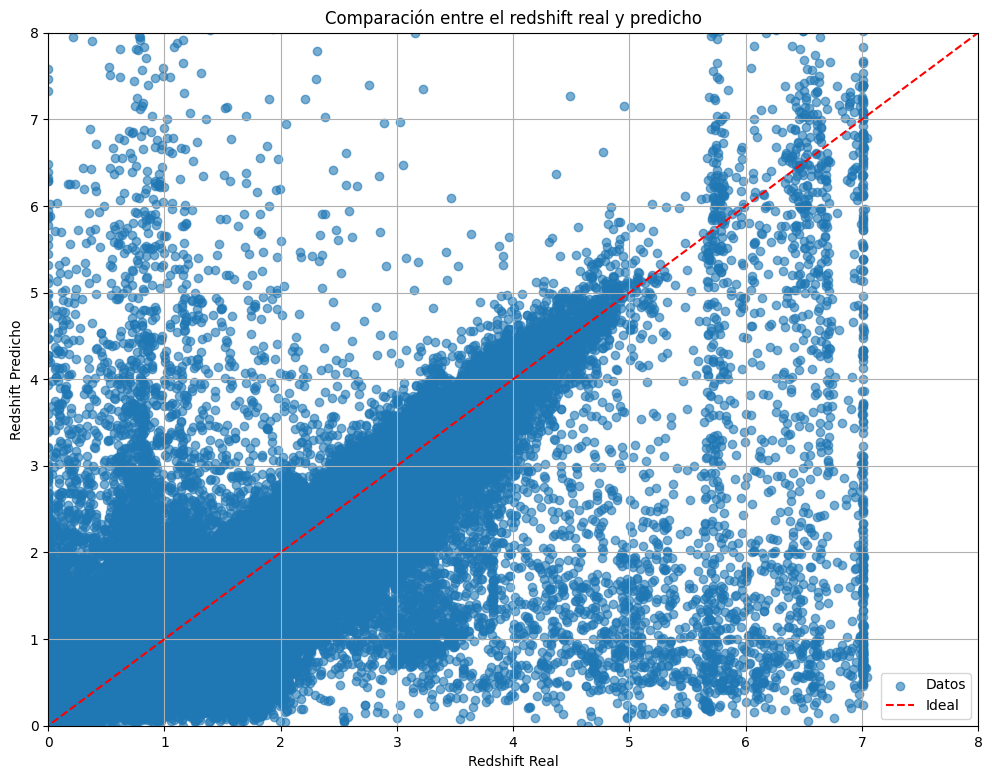

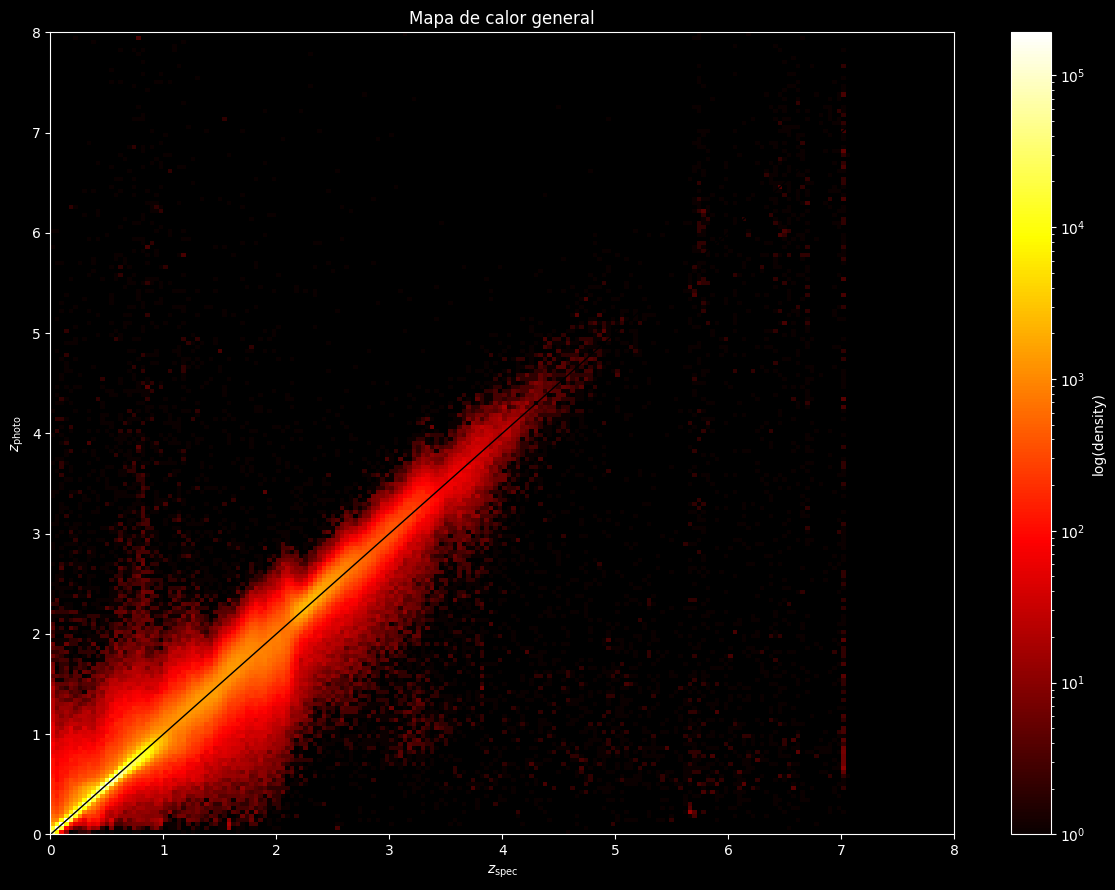

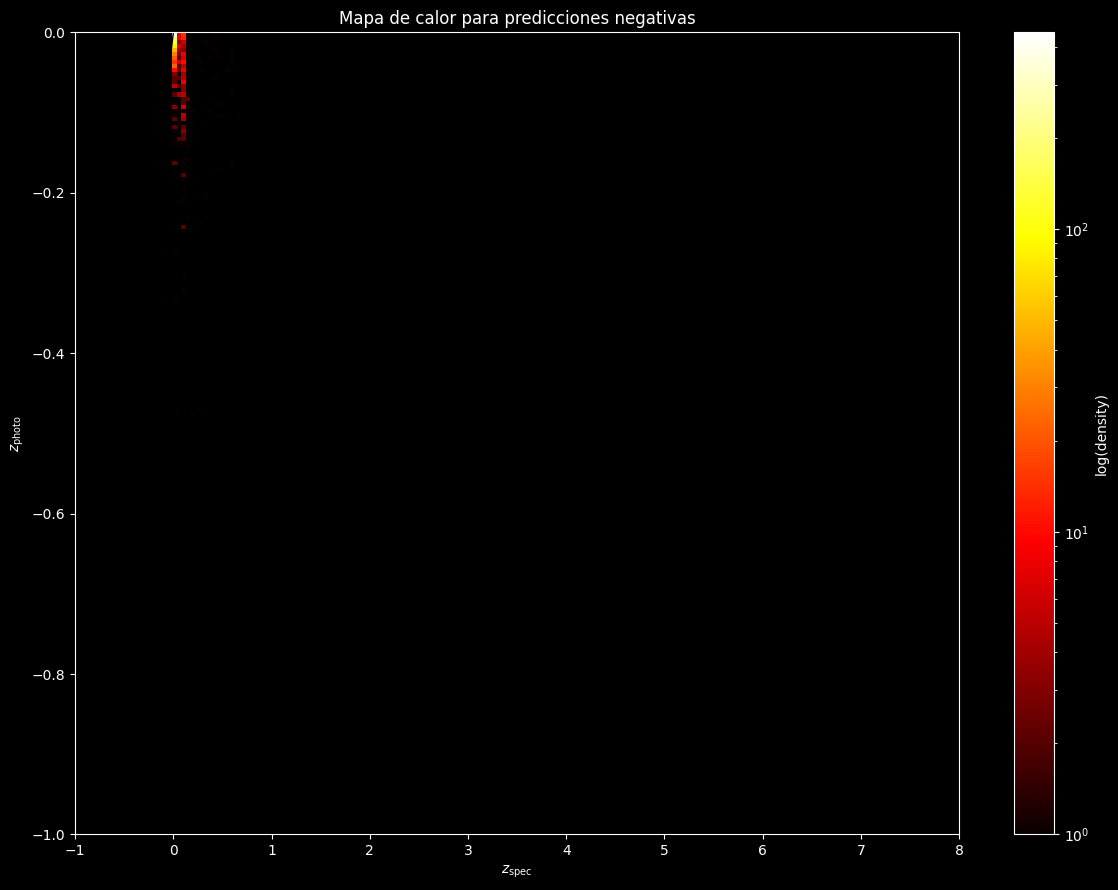

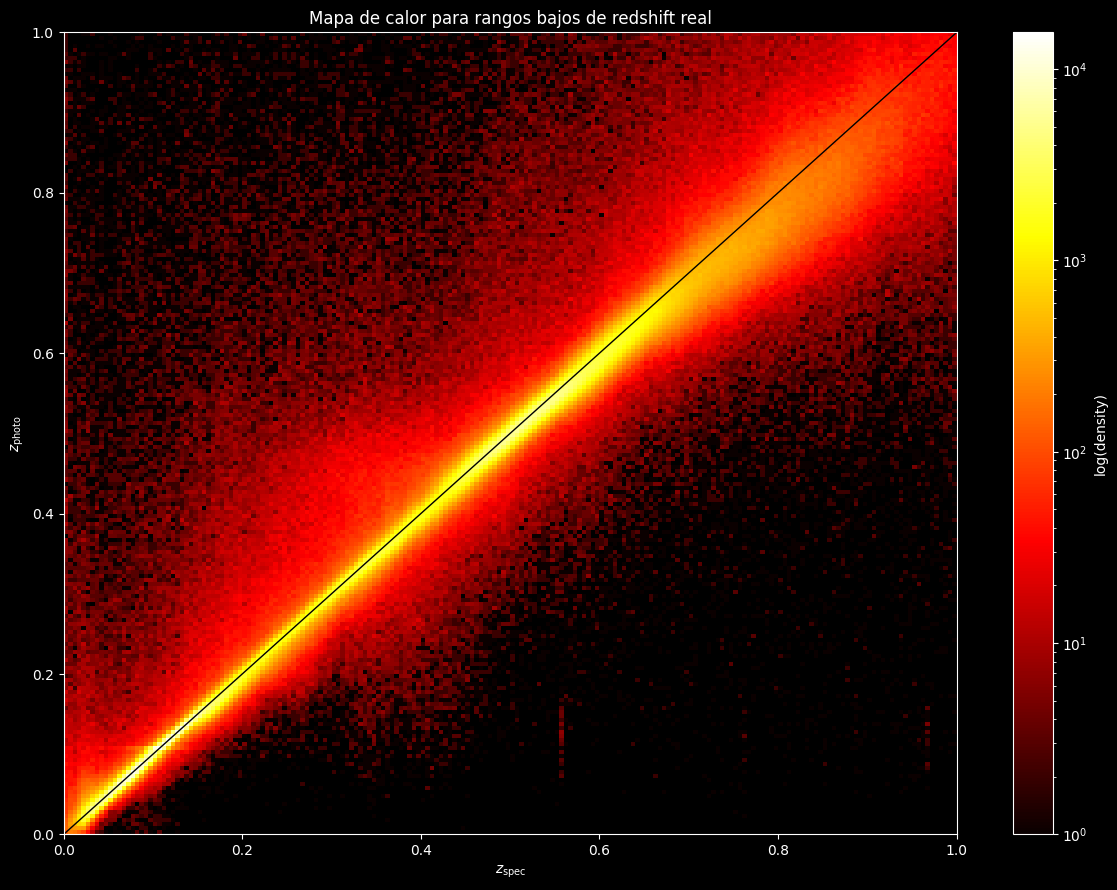

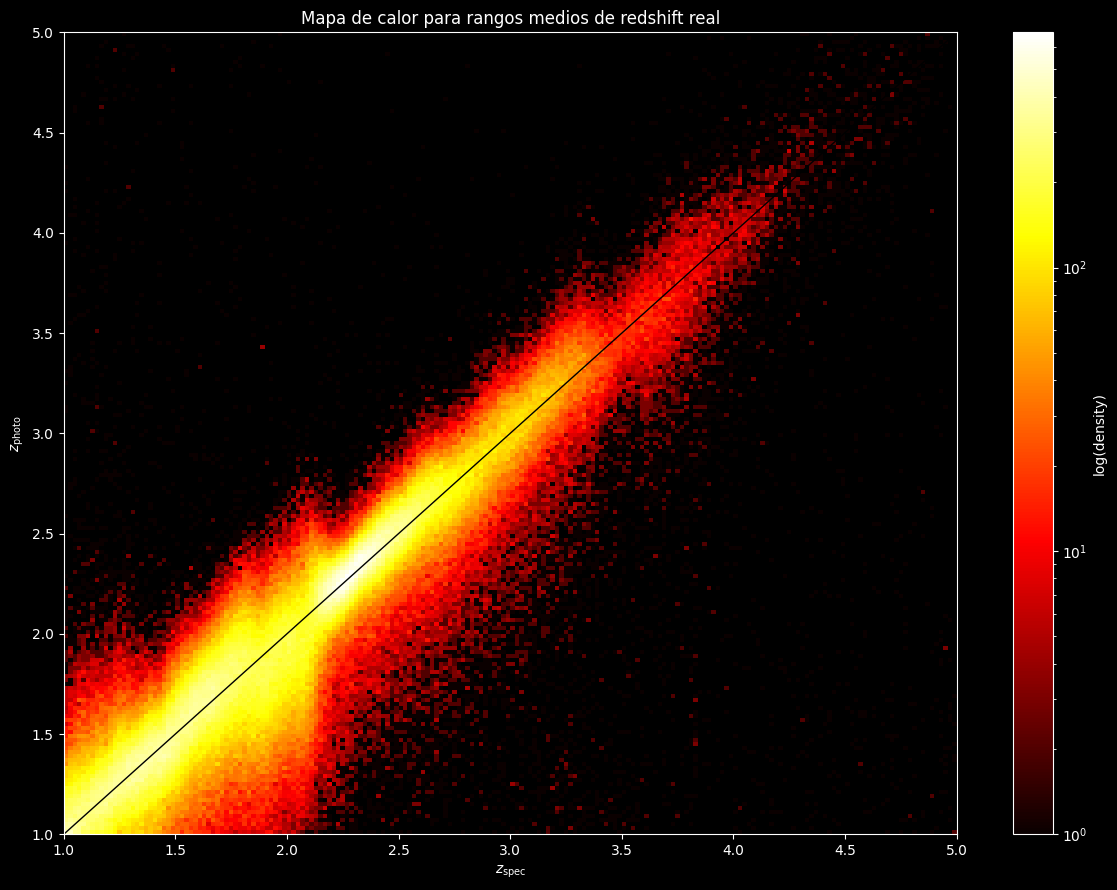

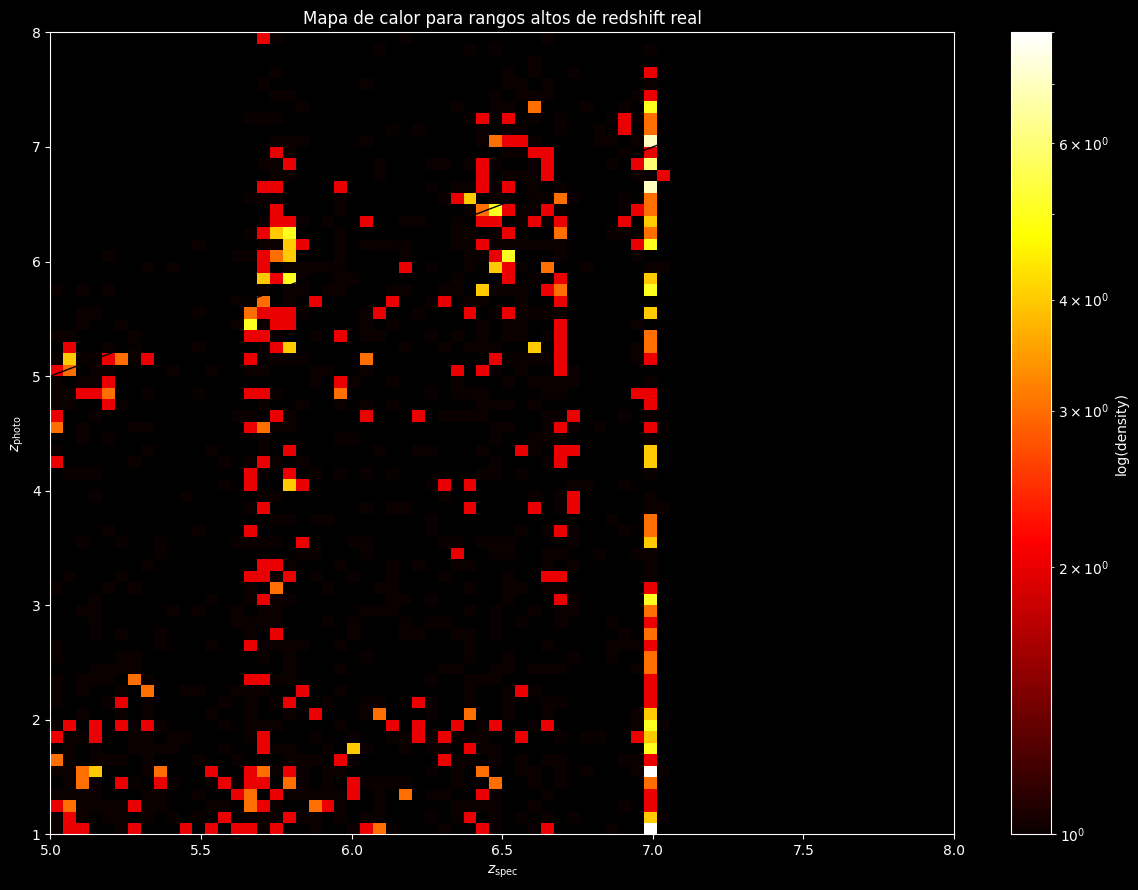

In [3]:
# Cargar los datos guardados
storage_dir = "storage"
predicted1 = np.load(os.path.join(storage_dir, "predicted1_CNN600k_0.npy"))
real1      = np.load(os.path.join(storage_dir, "real1_CNN600k_0.npy"))
predicted2 = np.load(os.path.join(storage_dir, "predicted2_CNN600k_0.npy"))
real2      = np.load(os.path.join(storage_dir, "real2_CNN600k_0.npy"))

# Concatenar ambos resultados
ypredicted = np.concatenate([predicted1, predicted2], axis=0)
yreal      = np.concatenate([real1, real2], axis=0)

# Asegurarse de que ambos sean vectores 1D
ypredicted = ypredicted.squeeze()     # Ahora tiene forma (N,)
yreal      = yreal.squeeze()          # Ahora tiene forma (N,)

# Calcular la correlacion lineal
correlation = np.corrcoef(yreal, ypredicted)[0, 1]

print(f"Correlación lineal: {correlation:.4f}")
print(f"Error medio: {np.mean(np.abs(yreal - ypredicted)):.6f}")
print(f"Número de muestras evaluadas: {len(yreal)}")


# Dispersion de puntos de z_real frente a z_predicho

plt.rcdefaults()
plt.figure(figsize=(12,9))
plt.scatter(yreal, ypredicted, alpha=0.6, label='Datos')
plt.xlabel('Redshift Real')
plt.ylabel('Redshift Predicho')
plt.title('Comparación entre el redshift real y predicho')
# Añadir la línea ideal (y=x)
min_val = min(yreal.min(), ypredicted.min())
max_val = max(yreal.max(), ypredicted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
plt.legend()
plt.grid(True)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()






# Mapa de calor de z_real frente a z_predicho estandar

plt.style.use('dark_background')

x_min, x_max = 0, 8
y_min, y_max = 0, 8

plt.figure(figsize=(12,9))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal,                 # z_spec (redshift "real")
    ypredicted,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor general')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()






# Mapa de calor de z_real frente a z_predicho para comprobar negatividad

plt.style.use('dark_background')

x_min, x_max = -1, 8
y_min, y_max = -1, 0

plt.figure(figsize=(12,9))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal,                 # z_spec (redshift "real")
    ypredicted,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor para predicciones negativas')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()






# Mapa de calor de z_real frente a z_predicho para comprobar rangos bajos

plt.style.use('dark_background')

x_min, x_max = 0, 1
y_min, y_max = 0, 1

plt.figure(figsize=(12,9))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal,                 # z_spec (redshift "real")
    ypredicted,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor para rangos bajos de redshift real')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()






# Mapa de calor de z_real frente a z_predicho para comprobar rangos intermedios

plt.style.use('dark_background')

x_min, x_max = 1, 5
y_min, y_max = 1, 5

plt.figure(figsize=(12,9))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal,                 # z_spec (redshift "real")
    ypredicted,            # z_photo (redshift "predicho")
    bins=200,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor para rangos medios de redshift real')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()







# Mapa de calor de z_real frente a z_predicho para comprobar rangos altos

plt.style.use('dark_background')

x_min, x_max = 5, 8
y_min, y_max = 1, 8

plt.figure(figsize=(12,9))

# Calculo del histograma 2D con escala logaritmica
counts, xedges, yedges, im = plt.hist2d(
    yreal,                 # z_spec (redshift "real")
    ypredicted,            # z_photo (redshift "predicho")
    bins=70,
    range=[[x_min, x_max], [y_min, y_max]],
    cmap='hot',
    norm=colors.LogNorm()  # Densidad logaritmica
)

cbar = plt.colorbar(im, label='log(density)')

plt.plot([x_min, x_max], [x_min, x_max], color='black', linewidth=1)
plt.xlabel(r'$z_{\mathrm{spec}}$')
plt.ylabel(r'$z_{\mathrm{photo}}$')
plt.title('Mapa de calor para rangos altos de redshift real')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

Redshift real: 2.9675276
Redshift predicho: 2.6844539642333984


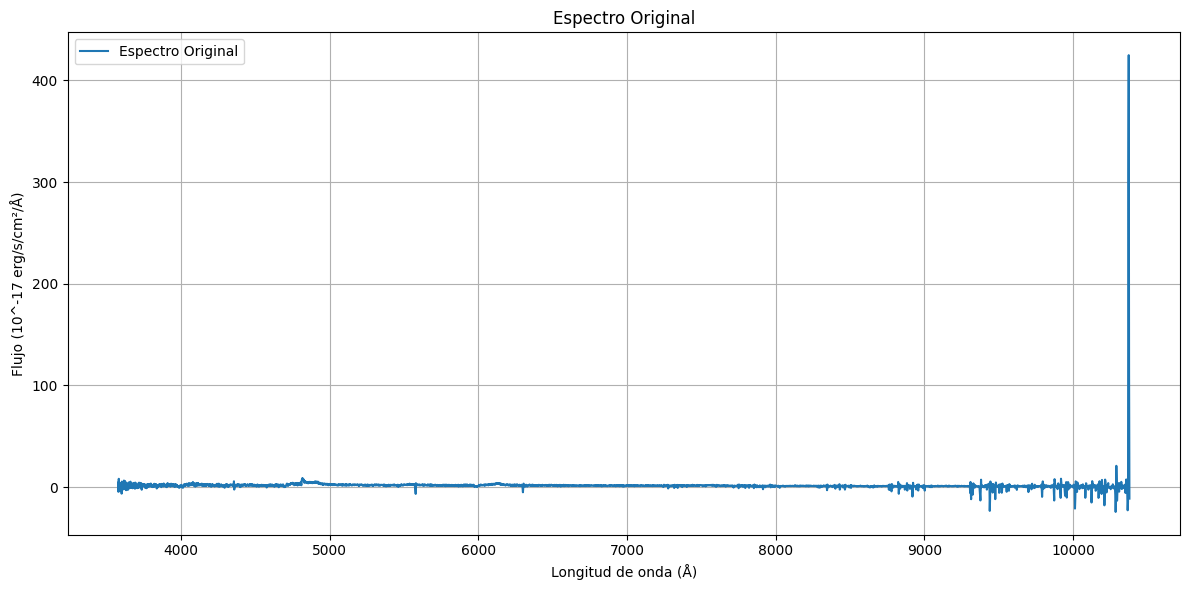

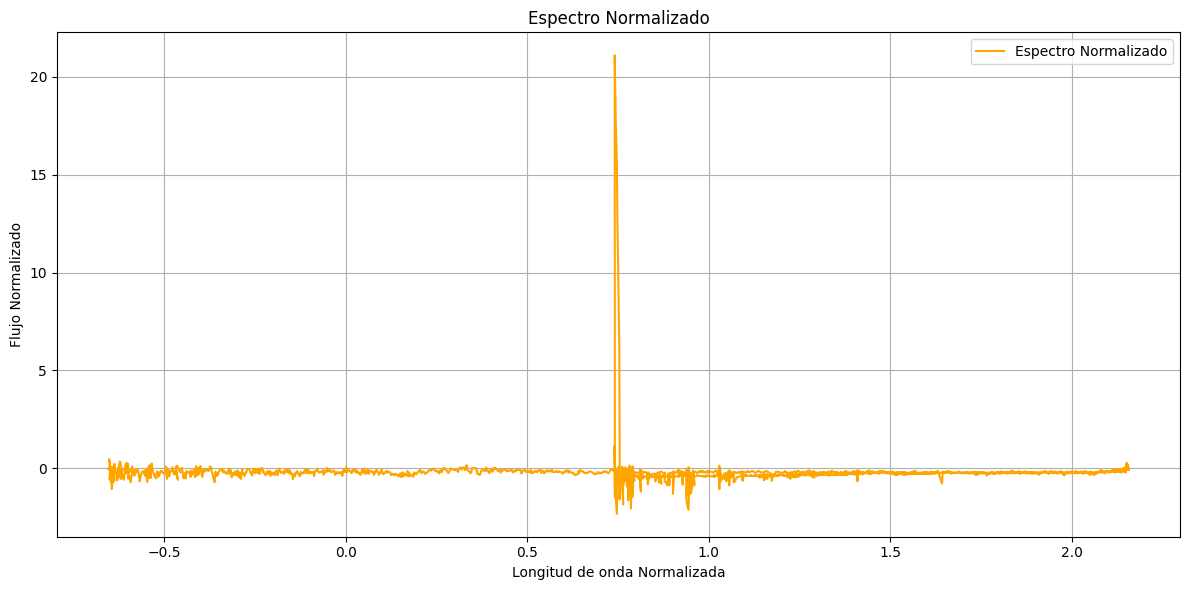

In [ ]:
# Obtener la lista inicial de archivos FITS
folder_path = r'spectrums'
files = [f for f in os.listdir(folder_path) if f.endswith('.fits')]
files = random.sample(files, len(files))
file_path = os.path.join(folder_path, files[0])

# Cargar el checkpoint del modelo y los escaladores
checkpoint = torch.load('storage/modelCNN_600k_0.pth', map_location=device)
modelCNN.load_state_dict(checkpoint['model_state_dict'])
modelCNN.eval()

# Los escaladores se encuentran en un diccionario con las claves "flux_scaler" y "wavelength_scaler"
with open('extra/scaler_fitted.pkl', 'rb') as f:
    scaler_dict = pickle.load(f)
flux_scaler = scaler_dict["flux_scaler"]
wavelength_scaler = scaler_dict["wavelength_scaler"]

# Abrir el archivo FITS y extraer datos
with fits.open(file_path) as hdul:
    test_flux = hdul[1].data["flux"]
    test_loglam = hdul[1].data["loglam"]
    test_redshift = hdul[2].data["Z"][0]

# Convertir loglam a wavelength
test_wavelength = 10 ** test_loglam

def expand_points(wavelength, flux, target_count=5000):
    # Convertir a listas para facilitar las inserciones
    wl = list(wavelength)
    fl = list(flux)
    
    # Calcular las diferencias absolutas entre puntos consecutivos
    diffs = [abs(fl[i+1] - fl[i]) for i in range(len(fl)-1)]
    # Obtener los indices ordenados de mayor a menor diferencia
    sorted_indices = sorted(range(len(diffs)), key=lambda i: diffs[i], reverse=True)
    
    # Insertar nuevos puntos utilizando los indices ordenados
    while len(wl) < target_count:
        # Se recorre la lista de indices en orden descendente para evitar problemas con el reordenamiento
        for idx in sorted_indices:
            if len(wl) >= target_count:
                break
            # Calcular la interpolacion lineal entre el punto idx y el siguiente
            new_wl = (wl[idx] + wl[idx+1]) / 2
            new_fl = (fl[idx] + fl[idx+1]) / 2
            # Insertar el nuevo punto en la posicion correspondiente
            wl.insert(idx+1, new_wl)
            fl.insert(idx+1, new_fl)
    
    return np.array(wl), np.array(fl)

# Asegurarse de tener exactamente num_points
test_wavelength, test_flux = expand_points(test_wavelength, test_flux, target_count=num_points)

# Preprocesamiento para el modelo

# Redimensionar cada canal para que tenga forma (1, num_points)
input_flux = test_flux.reshape(1, -1)              # (1, 5000)
input_wavelength = test_wavelength.reshape(1, -1)  # (1, 5000)

# Aplicar la normalizacion con los escaladores correspondientes
flux_scaled = flux_scaler.transform(input_flux)                     # (1, 5000)
wavelength_scaled = wavelength_scaler.transform(input_wavelength)   # (1, 5000)

# Reconstruir el input con dos canales: (2, 5000) y agregar dimension de batch => (1, 2, 5000)
input_scaled = np.stack([flux_scaled[0], wavelength_scaled[0]], axis=0)
input_scaled = input_scaled.reshape(1, 2, num_points)

# Convertir a tensor (usando torch.from_numpy para no saturar la memoria)
input_tensor = torch.from_numpy(input_scaled).to(device)

# Evaluacion del modelo
with torch.no_grad():
    predicted_redshift = modelCNN(input_tensor)

plt.rcdefaults()
print("Redshift real:", test_redshift)
print("Redshift predicho:", predicted_redshift.item())

# Representacion de espectros
plt.figure(figsize=(12, 6))
plt.plot(test_wavelength, test_flux, label="Espectro Original")
plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo (10^-17 erg/s/cm²/Å)")
plt.title("Espectro Original")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(wavelength_scaled.flatten(), flux_scaled.flatten(), label="Espectro Normalizado", color="orange")
plt.xlabel("Longitud de onda Normalizada")
plt.ylabel("Flujo Normalizado")
plt.title("Espectro Normalizado")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()